In [1]:
!pip install -q torchmetrics

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import torchmetrics
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
#up to 20GB to the
# You can write current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# reading in train and test data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

# filling unknown values with median from the same column
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

/tmp/ipykernel_18/327201593.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
/tmp/ipykernel_18/327201593.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [4]:
# picking the relevant features
features = ["Pclass", "Sex", "SibSp", "Parch", "Age", "Fare", "Embarked"]
columns_to_one_hot = ["Pclass", "Sex", "Embarked"]

# one-hot encode train and test data's features
train_data_encoded = pd.get_dummies(train_data[features], columns = columns_to_one_hot, dtype='int')
test_data_encoded = pd.get_dummies(test_data[features], columns = columns_to_one_hot, dtype='int')

# normalize everything
# Dani: normalizálás nélkül van, hogy elszáll a tanítás, emiatt a normalizálás a "best practice"
# Dani: viszont ugyanazzal a számmal normalizáld a train-t és a val-t is!
# Dani: itt a két fit_transform külön-külön számolja ki a train és a val halmaz minimumát és maximumát, ami nem feltétlenül ugyanaz a szám
# Dani: általában a train-re hívunk egy fit-et, és aztán mind a train-re, mind a val-ra, mind a test-re csinálunk egy transform-ot
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(train_data_encoded)
train_data_scaled = pd.DataFrame(min_max_scaler.transform(train_data_encoded))
test_data_scaled = pd.DataFrame(min_max_scaler.transform(test_data_encoded))

# splitting train_data_scaled into normalized, one-hot encoded training and validation dataset
train_X, val_X, train_labels, val_labels = train_test_split(train_data_scaled, train_data["Survived"], test_size=0.2, random_state=0)

# turn everything to a tensor
train_X = torch.tensor(train_X.values).to(torch.float32)
train_labels = torch.tensor(train_labels.values).to(torch.float32)
val_X = torch.tensor(val_X.values).to(torch.float32)
val_labels = torch.tensor(val_labels.values).to(torch.float32)

test_X = torch.tensor(test_data_scaled.values).to(torch.float32)

print(train_X.shape)

torch.Size([712, 12])


In [5]:
# defining the dataset for dataloaders
class MyDataset(Dataset):
    def __init__(self, tensor, labels):
        self.X = tensor
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.X[idx], self.labels[idx]

# making the minbatches for DL
train_ds = MyDataset(train_X, train_labels)
val_ds = MyDataset(val_X, val_labels)
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=True)

In [6]:
# defining the model with 3 hidden layers, 128 nodes each
model = nn.Sequential(
    nn.Linear(12, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 1),
    nn.Sigmoid()
)
criterion = nn.BCELoss()
acc = torchmetrics.classification.BinaryAccuracy() # pontosság számolásra
# az AdamW gyorsabban konvergál és van benne regularizáció, hogy elkerüld az overfit-et, én őt szoktam használni :)
# btw az SGD-t tipikusan momemntummal használják, itt egy példa: optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [7]:
# learning
epochs = 200
tot_train_loss = []
tot_val_loss = []
tot_train_acc = []
tot_val_acc = []
for e in range(epochs):
    for passengers, label in trainloader:
        optimizer.zero_grad()
        output = model(passengers).squeeze(-1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        tot_train_loss.append(loss.item())
        tot_train_acc.append(acc(output, label).item())
    else:
        with torch.no_grad():
            for passgrs, label in validationloader:
                val_out = model(passgrs).squeeze(-1)
                val_loss = criterion(val_out, label)
                tot_val_loss.append(val_loss.item())
                tot_val_acc.append(acc(val_out, label).item())
    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Acc: {:.4f}.. ".format(sum(tot_train_acc) / len(tot_train_acc)),
          "Test Acc: {:.4f}.. ".format(sum(tot_val_acc) / len(tot_val_acc)))


Epoch: 1/200..  Training Acc: 0.6068..  Test Acc: 0.6101.. 
Epoch: 2/200..  Training Acc: 0.6120..  Test Acc: 0.6074.. 
Epoch: 3/200..  Training Acc: 0.6137..  Test Acc: 0.6114.. 
Epoch: 4/200..  Training Acc: 0.6146..  Test Acc: 0.6127.. 
Epoch: 5/200..  Training Acc: 0.6174..  Test Acc: 0.6146.. 
Epoch: 6/200..  Training Acc: 0.6246..  Test Acc: 0.6214.. 
Epoch: 7/200..  Training Acc: 0.6319..  Test Acc: 0.6375.. 
Epoch: 8/200..  Training Acc: 0.6434..  Test Acc: 0.6521.. 
Epoch: 9/200..  Training Acc: 0.6597..  Test Acc: 0.6668.. 
Epoch: 10/200..  Training Acc: 0.6701..  Test Acc: 0.6799.. 
Epoch: 11/200..  Training Acc: 0.6791..  Test Acc: 0.6902.. 
Epoch: 12/200..  Training Acc: 0.6885..  Test Acc: 0.7000.. 
Epoch: 13/200..  Training Acc: 0.6960..  Test Acc: 0.7078.. 
Epoch: 14/200..  Training Acc: 0.7034..  Test Acc: 0.7151.. 
Epoch: 15/200..  Training Acc: 0.7107..  Test Acc: 0.7206.. 
Epoch: 16/200..  Training Acc: 0.7153..  Test Acc: 0.7252.. 
Epoch: 17/200..  Training Acc: 0.

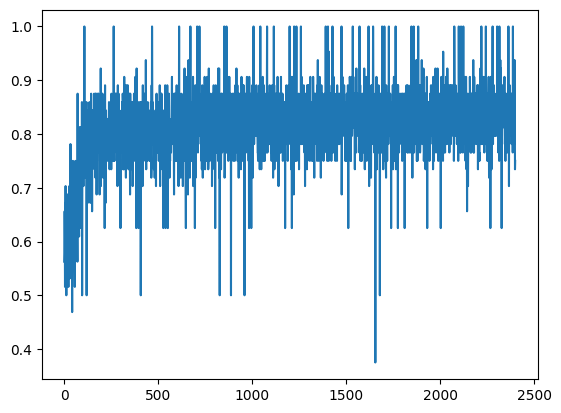

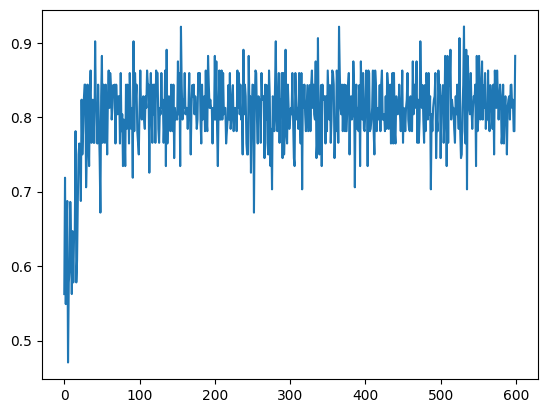

In [8]:
plt.plot(tot_train_acc)
plt.show()
plt.plot(tot_val_acc)
plt.show()

In [9]:
predictions = model(test_X)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': np.round(predictions.squeeze(-1).detach().numpy()).astype(int)})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


/tmp/ipykernel_18/4060105946.py:3: RuntimeWarning: invalid value encountered in cast
  output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': np.round(predictions.squeeze(-1).detach().numpy()).astype(int)})
